In [39]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import (
    StratifiedKFold, train_test_split,
    GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from sklearn.base import BaseEstimator, TransformerMixin

import optuna
from optuna.samplers import TPESampler
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.freq_maps = {}

    def fit(self, X, y=None):
        if self.cols is None:
            self.cols = list(X.columns)
        for col in self.cols:
            self.freq_maps[col] = X[col].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.cols:
            X_copy[col] = X_copy[col].map(self.freq_maps[col])
            X_copy[col] = X_copy[col].fillna(np.mean(list(self.freq_maps[col].values)))
        return X_copy

    def get_feature_names_out(self, input_features=None):
        return np.array(self.cols)


# LogisticRegression

In [20]:
df = pd.read_csv('./train.csv', index_col='id')

In [21]:
df_sample = df.sample(n=1_500_000, random_state=42)

X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=1_000_000,
    test_size=500_000,
    stratify=y,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train:\n{y_train.value_counts(normalize=True)}")

Train shape: (1000000, 10)
Test shape: (500000, 10)
Class balance in train:
Response
0    0.876795
1    0.123205
Name: proportion, dtype: float64


In [ ]:
high_card_cols = ['Region_Code', 'Policy_Sales_Channel']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']

preprocessor = ColumnTransformer(
    transformers=[
        ("high_cat", FrequencyEncoder(cols=high_card_cols), high_card_cols),
        ("bool", OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), bool_cols),
        ("ord", OrdinalEncoder(
            categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
            dtype=np.int32
        ), ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        solver='liblinear'
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100], # параметр регуляризации
    'classifier__penalty': ['l1', 'l2'] # тип регуляризации
}

In [24]:
def evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test, name):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    metrics = {
        'Method': name,
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }
    cm = confusion_matrix(y_test, y_pred)
    return metrics, cm

In [27]:
results = []
conf_matrices = {}

### GridSearchCV

In [ ]:
print("Запуск GridSearchCV...")
grid = GridSearchCV(
    full_pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=0
)
grid.fit(X_train, y_train)
met_grid, cm_grid = evaluate_pipeline(grid, X_train, X_test, y_train, y_test, "GridSearchCV")
results.append(met_grid)
conf_matrices["GridSearchCV"] = cm_grid
print("GridSearchCV завершён.")

Запуск GridSearchCV...
GridSearchCV завершён.


### RandomizedSearchCV

In [ ]:
print("Запуск RandomizedSearchCV...")
rand = RandomizedSearchCV(
    full_pipeline, param_grid, n_iter=20, cv=cv, scoring='f1',
    n_jobs=-1, random_state=42, verbose=0
)
rand.fit(X_train, y_train)
met_rand, cm_rand = evaluate_pipeline(rand, X_train, X_test, y_train, y_test, "RandomizedSearchCV")
results.append(met_rand)
conf_matrices["RandomizedSearchCV"] = cm_rand
print("RandomizedSearchCV завершён.")

Запуск RandomizedSearchCV...
RandomizedSearchCV завершён.


### Optuna

In [ ]:
print("Запуск Optuna...")
def optuna_objective(trial):
    C = trial.suggest_float('C', 0.01, 100, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            C=C, penalty=penalty, solver='liblinear',
            class_weight='balanced', max_iter=1000, random_state=42
        ))
    ])
    
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_val)
        scores.append(f1_score(y_val, y_pred))
    return -np.mean(scores)

optuna_study = optuna.create_study(sampler=TPESampler(seed=42))
optuna_study.optimize(optuna_objective, n_trials=30)

best_optuna_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        **optuna_study.best_params,
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

met_optuna, cm_optuna = evaluate_pipeline(best_optuna_pipe, X_train, X_test, y_train, y_test, "Optuna")
results.append(met_optuna)
conf_matrices["Optuna"] = cm_optuna
print("Optuna завершён.")

[I 2025-12-06 08:09:15,455] A new study created in memory with name: no-name-15e80990-5d15-49cb-8ceb-9bd726f091a5


Запуск Optuna...


[I 2025-12-06 08:09:55,397] Trial 0 finished with value: -0.4021951044801316 and parameters: {'C': 0.31489116479568624, 'penalty': 'l1'}. Best is trial 0 with value: -0.4021951044801316.
[I 2025-12-06 08:10:33,709] Trial 1 finished with value: -0.4021957778867823 and parameters: {'C': 2.481040974867813, 'penalty': 'l1'}. Best is trial 1 with value: -0.4021957778867823.
[I 2025-12-06 08:11:13,699] Trial 2 finished with value: -0.4021976797619691 and parameters: {'C': 0.017073967431528128, 'penalty': 'l1'}. Best is trial 2 with value: -0.4021976797619691.
[I 2025-12-06 08:11:28,143] Trial 3 finished with value: -0.4021957778867823 and parameters: {'C': 6.79657809075816, 'penalty': 'l2'}. Best is trial 2 with value: -0.4021976797619691.
[I 2025-12-06 08:12:06,307] Trial 4 finished with value: -0.4021957778867823 and parameters: {'C': 21.368329072358772, 'penalty': 'l1'}. Best is trial 2 with value: -0.4021976797619691.
[I 2025-12-06 08:12:19,888] Trial 5 finished with value: -0.4021977617

Optuna завершён.


### Hyperopt

In [ ]:
print("Запуск Hyperopt...")
def hyperopt_objective(params):
    C = params['C']
    penalty = params['penalty']
    
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            C=C, penalty=penalty, solver='liblinear',
            class_weight='balanced', max_iter=1000, random_state=42
        ))
    ])
    
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_val)
        scores.append(f1_score(y_val, y_pred))
    return {'loss': -np.mean(scores), 'status': STATUS_OK}

space = {
    'C': hp.loguniform('C', np.log(0.01), np.log(100)),
    'penalty': hp.choice('penalty', ['l1', 'l2'])
}

trials = Trials()
best_hp = fmin(
    fn=hyperopt_objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials,
    rstate=np.random.default_rng(42)
)

penalty_map = ['l1', 'l2']
best_params_hp = {
    'C': best_hp['C'],
    'penalty': penalty_map[best_hp['penalty']]
}

best_hyperopt_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        **best_params_hp,
        solver='liblinear',
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

met_hyperopt, cm_hyperopt = evaluate_pipeline(best_hyperopt_pipe, X_train, X_test, y_train, y_test, "Hyperopt")
results.append(met_hyperopt)
conf_matrices["Hyperopt"] = cm_hyperopt
print("Hyperopt завершён.")

Запуск Hyperopt...
100%|██████████| 30/30 [11:05<00:00, 22.18s/trial, best loss: -0.4022024161616762] 
Hyperopt завершён.


### HalvingGridSearchCV

In [ ]:
print("Запуск HalvingGridSearchCV...")
halving_grid = HalvingGridSearchCV(
    full_pipeline,
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=0,
    random_state=42,
    factor=3,
    resource='n_samples',
    max_resources='auto'
)

halving_grid.fit(X_train, y_train)
met_halving, cm_halving = evaluate_pipeline(halving_grid, X_train, X_test, y_train, y_test, "HalvingGridSearchCV")
results.append(met_halving)
conf_matrices["HalvingGridSearchCV"] = cm_halving
print("HalvingGridSearchCV завершён.")

Запуск HalvingGridSearchCV...
HalvingGridSearchCV завершён.


In [37]:
results_df = pd.DataFrame(results)
print("СВОДКА РЕЗУЛЬТАТОВ")
print("="*60)
print(results_df.round(4))

СВОДКА РЕЗУЛЬТАТОВ
                Method  Precision  Recall      F1  ROC-AUC
0         GridSearchCV     0.2535  0.9805  0.4029   0.8353
1   RandomizedSearchCV     0.2535  0.9805  0.4029   0.8353
2               Optuna     0.2535  0.9805  0.4029   0.8353
3             Hyperopt     0.2535  0.9805  0.4029   0.8353
4  HalvingGridSearchCV     0.2535  0.9804  0.4029   0.8353


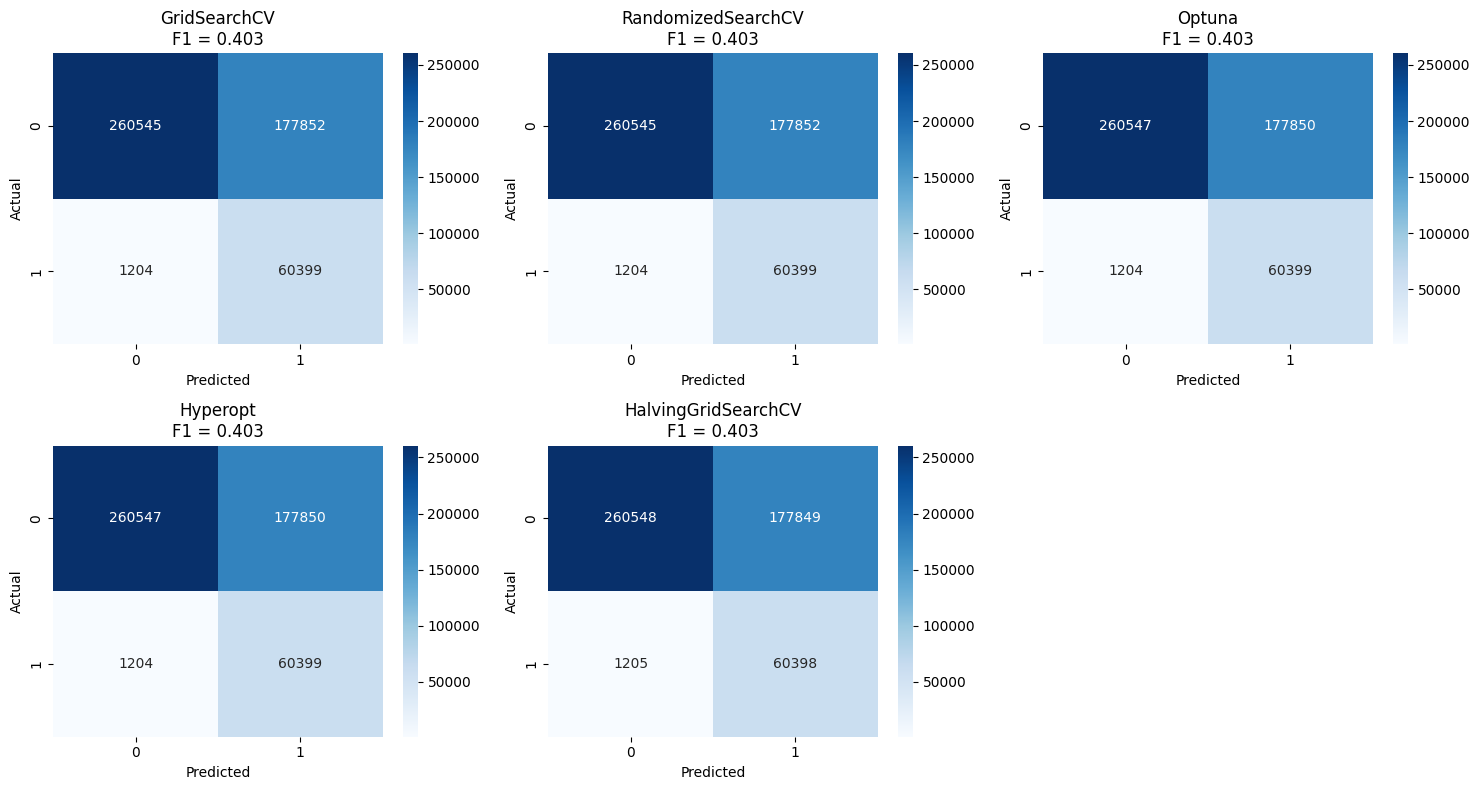

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

methods = list(conf_matrices.keys())
n = len(methods)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten() if n > 1 else [axes]

for i, method in enumerate(methods):
    cm = conf_matrices[method]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    f1_val = results_df.loc[results_df['Method'] == method, 'F1'].values[0]
    axes[i].set_title(f'{method}\nF1 = {f1_val:.3f}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Выводы:

- Модель очень хорошо находит True Positives - Recall = 0.98
- Но также очень много False Positives - Precision = 0.25

**Обоснование выбора F1-score**: для задачи предсказания отклика на предложение доп. страховки оптимальная метрика для подбора гиперпараметров - F1-score, так как она фокусируются на качестве предсказания положительного класса (Response = 1) и устойчива к дисбалансу.

**Обоснование одинаковых результатов**:
1. Один и тот же алгоритм + один и тот же набор гиперпараметров - в конечном итоге находят одну и ту же оптимальную комбинацию параметров:
- Пространство гиперпараметров очень маленькое
- Модель линейная
- Все методы стабильно сходятся к одному и тому же решению
2. Кросс-валидация стратифицированная, данные одинаковые - каждый метод работает с одинаковыми фолдами, поэтому и оценка F1 на валидации одинакова
3. Финальная модель обучается на одном и том же X_train, y_train - после подбора все методы возвращают одну и ту же модель (с одними и теми же параметрами), поэтому предсказания на тесте идентичны, следовательно, матрицы ошибок идентичны

**Итог гипероптимизации:**
- Базовый уровень - GridSearchCV
- Продвинутый уровень - HalvingGridSearchCV